In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import scipy.stats as stats

import scipy
from scipy import optimize
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from multiprocessing import Pool
from matplotlib.colors import LinearSegmentedColormap
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

## The reproducibility of cellular composition

In [3]:
data_quality = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/visium_data_quality.csv',index_col=0)

slide_self = ['P77_A1','P77_B1','P130_C1','P130_D1','P131_A1','P131_B1', 'P136_C1', 'P136_D1','P137_A1','P137_B1']
slide_publicy = ['T_243','T_248','T_251','T_255','T_259','T_260','T_262','T_266','T_269','T_275','T_296','T_334','Visium_S1']

slide_list = slide_self + slide_publicy

## Load c2location info and filter

In [4]:
spatial_domain = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/spatial_domain_table.csv',index_col=0)
all_spot_c2location = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/all_spots_c2location.csv',index_col=0)

'no filter'
pass_QC_1 = all_spot_c2location.loc[all_spot_c2location.sum(axis=1) >= 0].index
'remove overlapping regions'
pass_QC_2 = pd.DataFrame(all_spot_c2location.sum(axis=1)).sort_values(0)[:int(all_spot_c2location.shape[0]*0.90)].index.tolist()
pass_QC = np.intersect1d(pass_QC_1,pass_QC_2).tolist()

domain_list = [8,2,9 ,0,4,3, 7,1 ,5 ,6]

all_spot_c2location_proportion = all_spot_c2location

## Generate cell type proportion of spatial domain

In [5]:
domain_cell_types = pd.DataFrame(columns=all_spot_c2location_proportion.columns)
num_cut_off = 50
for domain in domain_list:
    for slide in slide_list:
        num = len( np.intersect1d(spatial_domain[spatial_domain['spatial_domain'] == domain].index,data_quality.loc[data_quality['sample'] == slide].index ) )
        if num >= num_cut_off:
            spots = np.intersect1d( np.intersect1d(spatial_domain[spatial_domain['spatial_domain'] == domain].index,data_quality.loc[data_quality['sample'] == slide].index ), pass_QC )
            name = 'D'+str(domain)+'_'+slide
            domain_cell_types.loc[name] = all_spot_c2location_proportion.loc[spots].mean(axis=0)
            

domain_cell_types_zscore = pd.DataFrame(index=domain_cell_types.index,columns=domain_cell_types.columns)

for celltype in domain_cell_types.columns:
    domain_cell_types_zscore[celltype] = stats.zscore(domain_cell_types[celltype])

## PCC

In [6]:
domain_pearson_corr = pd.DataFrame(index=domain_cell_types_zscore.index,columns=domain_cell_types_zscore.index)
for domain in domain_pearson_corr.index:
    for item in domain_pearson_corr.columns:
        domain_pearson_corr.loc[domain][item] = stats.pearsonr(domain_cell_types_zscore.loc[domain],domain_cell_types_zscore.loc[item])[0]

domain_pearson_corr[list(domain_pearson_corr.columns)]=domain_pearson_corr[list(domain_pearson_corr.columns)].astype(float)

## Plot

In [8]:
domain_color_dict = { 0:'#CE3278',4:'#982581',3:'#762A86', 7:'#81C08F', 1:'#5DB998',5:'#B43826', 6:'#F4A947' ,2:'#AFB4B7',8:'#CDBEAE',9:'#6A6A6A' }

row_color = pd.DataFrame(index=domain_pearson_corr.index,columns=['domain'])
row_color['domain'] = [ domain_color_dict[int(item.split('_')[0].split('D')[1])] for item in row_color.index ] 

mask_matrix = pd.DataFrame(index=domain_pearson_corr.index,columns=domain_pearson_corr.columns)
for i,row in enumerate(domain_pearson_corr.index):
    for j,col in enumerate(domain_pearson_corr.columns):
        if j > i :
            mask_matrix.loc[row][col] = True
        else :
            mask_matrix.loc[row][col] = False

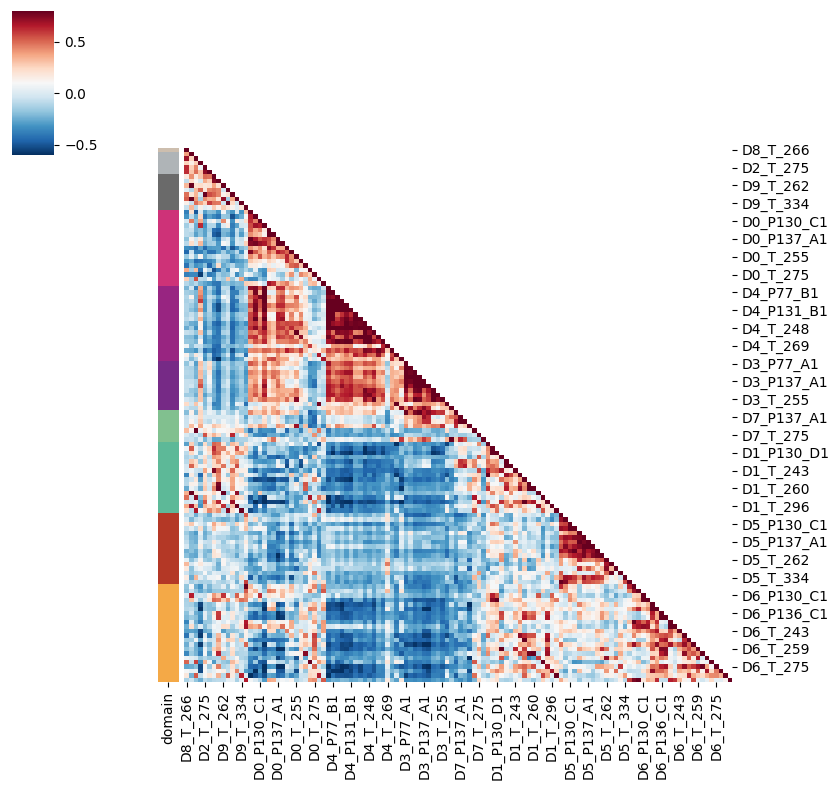

In [9]:
'sample corrlation'
sns.clustermap(domain_pearson_corr,cmap='RdBu_r',row_cluster=False,col_cluster=False,figsize=(8.5,8),row_colors=row_color,vmax=0.8,vmin=-0.6,mask = mask_matrix)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/In_depth/figure/result_1/domain_proportion_corr.pdf')

## The reproducibility of gene expression

In [ ]:
'Load gene expressopm data'

In [22]:
spot_norm = pd.DataFrame()

norm = pd.read_csv('/home/qukun/ccp1997/GBM_10X/analysis_part3/visium/totle/'+'P77_A1'+'/spot_norm.csv',index_col=0)
gene_list = norm.loc[norm.sum(axis=1) !=0].index

for k,slide in enumerate(slide_list):
    if k <= 9: 
        norm = pd.read_csv('/home/qukun/ccp1997/GBM_10X/analysis_part3/visium/totle/'+slide+'/spot_norm.csv',index_col=0) 
        tmp_gene_list = norm.loc[norm.sum(axis=1) !=0].index
        gene_list = np.intersect1d(gene_list,tmp_gene_list)
        norm.columns = [ item.split('.')[0]+'-'+str(k+1)  for item in norm.columns]
        for gene in norm.index:
            norm.loc[gene] = scipy.stats.zscore(norm.loc[gene])
        norm = norm.fillna(0)
        spot_norm = pd.concat([spot_norm,norm],axis=1)
    else :
        norm = pd.read_csv('/home/qukun/ccp1997/GBM_VISIUM/public_data/totle/'+slide+'_result'+'/spot_norm.csv',index_col=0) 
        tmp_gene_list = norm.loc[norm.sum(axis=1) !=0].index
        gene_list = np.intersect1d(gene_list,tmp_gene_list)
        norm.columns = [ item.split('.')[0]+'-'+str(k+1)  for item in norm.columns]
        for gene in norm.index:
            norm.loc[gene] = scipy.stats.zscore(norm.loc[gene])
        norm = norm.fillna(0)
        spot_norm = pd.concat([spot_norm,norm],axis=1)
spot_norm = spot_norm.fillna(0)

spot_norm = spot_norm.loc[gene_list]

In [ ]:
'filter'

In [34]:
spatial_domain = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/spatial_domain_table.csv',index_col=0)
all_spot_c2location = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/visium_matrix/all_spots_c2location.csv',index_col=0)

'no filter'
pass_QC_1 = all_spot_c2location.loc[all_spot_c2location.sum(axis=1) >= 0].index
'remove overlapping regions'
pass_QC_2 = pd.DataFrame(all_spot_c2location.sum(axis=1)).sort_values(0)[:int(all_spot_c2location.shape[0]*0.90)].index.tolist()
pass_QC = np.intersect1d(pass_QC_1,pass_QC_2).tolist()

domain_list = [8,2,9 ,0,4,3, 7,1 ,5 ,6]

## generate average gene expression of spatial domains

In [41]:
all_spot_c2location_proportion = all_spot_c2location
domain_exp = pd.DataFrame(columns=spot_norm.index)
num_cut_off = 50
for domain in domain_list:
    for slide in slide_list:
        num = len( np.intersect1d(spatial_domain[spatial_domain['spatial_domain'] == domain].index,data_quality.loc[data_quality['sample'] == slide].index ) )
        if num >= num_cut_off:
            spots = np.intersect1d( np.intersect1d(spatial_domain[spatial_domain['spatial_domain'] == domain].index,data_quality.loc[data_quality['sample'] == slide].index ), pass_QC )
            name = 'D'+str(domain)+'_'+slide
            domain_exp.loc[name] = spot_norm[spots].mean(axis=1)
            

In [45]:
domain_pearson_corr = pd.DataFrame(index=domain_exp.index,columns=domain_exp.index)
for domain in domain_pearson_corr.index:
    for item in domain_pearson_corr.columns:
        domain_pearson_corr.loc[domain][item] = stats.pearsonr(domain_exp.loc[domain],domain_exp.loc[item])[0]

domain_pearson_corr[list(domain_pearson_corr.columns)]=domain_pearson_corr[list(domain_pearson_corr.columns)].astype(float)

## Plot

In [86]:
domain_color_dict = { 0:'#CE3278',4:'#982581',3:'#762A86', 7:'#81C08F', 1:'#5DB998',5:'#B43826', 6:'#F4A947' ,2:'#AFB4B7',8:'#CDBEAE',9:'#6A6A6A' }

row_color = pd.DataFrame(index=domain_pearson_corr.index,columns=['domain'])
row_color['domain'] = [ domain_color_dict[int(item.split('_')[0].split('D')[1])] for item in row_color.index ] 

mask_matrix = pd.DataFrame(index=domain_pearson_corr.index,columns=domain_pearson_corr.columns)
for i,row in enumerate(domain_pearson_corr.index):
    for j,col in enumerate(domain_pearson_corr.columns):
        if j > i :
            mask_matrix.loc[row][col] = False
        else :
            mask_matrix.loc[row][col] = True

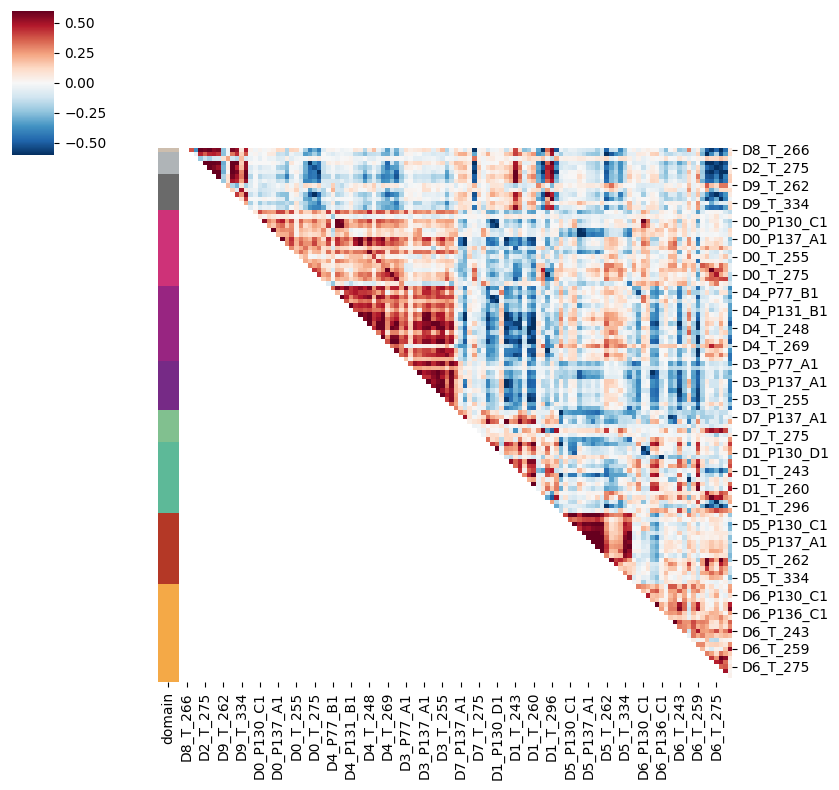

In [92]:
sns.clustermap(domain_pearson_corr,cmap='RdBu_r',row_cluster=False,col_cluster=False,figsize=(8.5,8),row_colors=row_color,mask = mask_matrix,vmax=0.6,vmin=-0.6)
#plt.savefig('/home/qukun/ccp1997/GBM_10X/In_depth/figure/result_1/domain_gene_exp_corr.pdf')